# EG vs. DigitalOcean

In August 2016 we've seen claims that encrypted connection from Egypt to DigitalOcean hosts are heavily throttled.

Based on our testing, the `digitalocean.pcap` file contains the record of several thousand attempts to establish HTTPS connection to [alexmerkel.com](https://alexmerkel.com) from an Egyptian ISP.

## Massaging the data

In [1]:
!tshark -r digitalocean.pcap -n -T fields \
  -e frame.number \
  -e frame.time_epoch \
  -e tcp.flags.str \
  -e tcp.srcport -e tcp.dstport \
  -e tcp.seq -e tcp.ack \
  -e tcp.options.timestamp.tsval -e tcp.options.timestamp.tsecr >pcap.tsv

`RST` packets from our host have no [TCP timestamp](https://en.wikipedia.org/wiki/Transmission_Control_Protocol#TCP_timestamps) options, so it's easier to filter them out when they don't provide any valuable information.

In [2]:
!set -o xtrace; awk '!($$5 == 443 && $$3 == "*********R**")' pcap.tsv >good.tsv

+ awk !($5 == 443 && $3 == "*********R**") pcap.tsv


In [3]:
!wc -l pcap.tsv good.tsv

  196941 pcap.tsv
  196922 good.tsv
  393863 total


The dump has ~200k packets.

In [4]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pylab as plt
fromtimestamp = datetime.datetime.fromtimestamp

In [5]:
%matplotlib inline

In [6]:
head = 'no time_epoch flags srcport dstport seq ack tsval tsecr'.split()
types =  [np.uint32, np.float64, str, np.uint16, np.uint16, np.uint32, np.uint32, np.uint32, np.uint32]
d = pd.read_csv('good.tsv', delimiter='\t',
            names=head,
            dtype=dict(zip(head, types)))
d.time_epoch -= d.time_epoch.min() # to see milliseconds better

There are some TCP packets arriving from the server. It's possible to use TCP timestamps to understand RTT to the server better as server echoes last seen client's TCP timestamp back. PCAPs contain the exact wall clock timestamp corresponding to the client's TCP timestamp which makes it possible to estimate RTT.

In [7]:
smpl = (54832, 15126214) # just a sample

In [8]:
resp = d[d.srcport == 443]
resp = resp.drop_duplicates(['dstport', 'tsecr'], keep='first')
resp = resp.set_index(['dstport', 'tsecr'], verify_integrity=True)
resp.index.rename(['port', 'tcpts'], inplace=True)
rs = resp.loc[smpl]
rs

no                   30313
time_epoch         1723.59
flags         *******A****
srcport                443
seq                      1
ack                    297
tsval            241524960
Name: (54832, 15126214), dtype: object

In [9]:
req = d[d.dstport == 443]
req[(req.srcport == smpl[0]) & (req.tsval == smpl[1])]

,no,time_epoch,flags,srcport,dstport,seq,ack,tsval,tsecr
30289,30294,1722.474151,*******A****,54832,443,1,1,15126214,241524681
30290,30295,1722.475029,*******AP***,54832,443,1,1,15126214,241524681


Several TCP packets *may* have the same timestamp as the TCP clock resolution is not very high. For example, Linux determines TCP timestamp resolution based on `HZ` variable, one of common `HZ` values is 250, which leads to `4ms` precision of TCP timestamp.

The following code takes the very first packet in a packet series with the same TCP timestamp and creates a table to calculate RTT.

In [10]:
req = d[d.dstport == 443]
req = req.drop_duplicates(['srcport', 'tsval'], keep='first')
req = req.set_index(['srcport', 'tsval'], verify_integrity=True) # cross-verify with `first`
req.index.rename(['port', 'tcpts'], inplace=True)
req.loc[smpl]

no                   30294
time_epoch         1722.47
flags         *******A****
dstport                443
seq                      1
ack                      1
tsecr            241524681
Name: (54832, 15126214), dtype: object

RTT for every reply is calculated [joining](https://en.wikipedia.org/wiki/Join_%28SQL%29) corresponding request to it.

In [11]:
prod = resp.join(req, lsuffix='_resp', rsuffix='_req')

In [12]:
req.shape, resp.shape, prod.shape

((187997, 7), (5976, 7), (5976, 14))

Every response gets a corresponding request which is not surprising as tcpdump running at client have not missed any requests. Only 3% of TCP requests got some TCP reply.

In [13]:
prod.loc[smpl][['time_epoch_req', 'time_epoch_resp']]

time_epoch_req     1722.47
time_epoch_resp    1723.59
Name: (54832, 15126214), dtype: object

So pre-processing is done and actual RTT values can be studied now.

## TCP Timestamps give us some clue regarding RTT

In [14]:
delay = (prod.time_epoch_resp - prod.time_epoch_req)

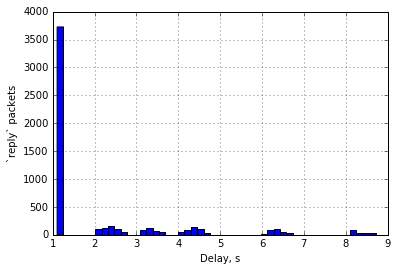

In [15]:
delay[delay < 10].hist(bins=50)
plt.xlabel('Delay, s')
plt.ylabel('`reply` packets') ;

It looks like usual RTT of TCP re-transmissions: the very first re-transmission happens after one second as soon as there is no data to calculate better RTO (re-transmission timeout) at this moment. Another possibility is that it's a real link latency, but this hypothesis is refuted by plain `ping`.

Let's look at the histogram with a bit different resolution:

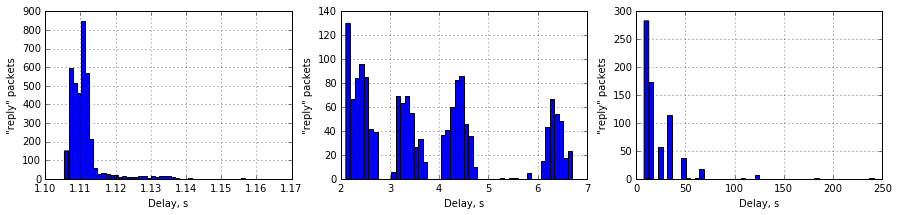

In [16]:
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(3)
for i, ndx in enumerate([delay < 1.5, (delay >= 1.5) & (delay < 7.5), delay >= 7.5]):
    ax = fig.add_subplot(1, 3, i+1)
    delay[ndx].hist(bins=50, ax=ax)
    ax.set_xlabel('Delay, s')
    ax.set_ylabel('"reply" packets') ;

## Bufferbloat or dropped packet?

Another possible explanation of packet delay is the [Bufferbloat effect](https://en.wikipedia.org/wiki/Bufferbloat). In this case there will be a router between the client and the server causing significant latency. It's hard to estimate this latency precisely, but it's possible to estimate the *variance* of the latency assuming that the server TCP Timestamp clock is ticking in a linear fashion, and that's true at least for Linux servers.

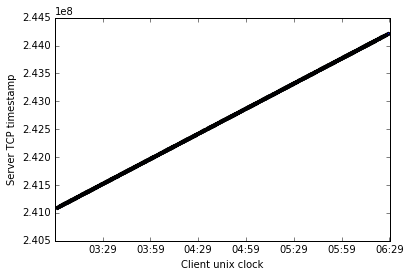

In [17]:
resp = d[d.srcport == 443]
plt.scatter(map(fromtimestamp, resp.time_epoch), resp.tsval, marker='.')
plt.xlim(fromtimestamp(resp.time_epoch.min() - 60), fromtimestamp(resp.time_epoch.max() + 60))
plt.xlabel('Client unix clock')
plt.ylabel('Server TCP timestamp')
plt.axes().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))

Well, it looks pretty linear. It's possible to estimate tick length & clock offset of TCP timestamps fitting simple linear model to the data.

In [18]:
# Whoa! Machine learning!
slope, inters = np.linalg.lstsq(np.vstack([resp.tsval, np.ones_like(resp.tsval)]).T, resp.time_epoch)[0]
print 'One TCP Timestamp tick is %f ms, HZ ~%d' % (slope, 1 / slope)

One TCP Timestamp tick is 0.004000 ms, HZ ~250


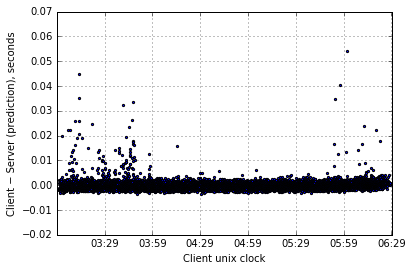

In [19]:
fiterr = resp.time_epoch - (resp.tsval * slope + inters)

plt.scatter(map(fromtimestamp, resp.time_epoch), fiterr, marker='.')
plt.xlim(fromtimestamp(resp.time_epoch.min() - 60), fromtimestamp(resp.time_epoch.max() + 60))
plt.xlabel('Client unix clock')
plt.ylabel(u'Client − Server (prediction), seconds')
plt.axes().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
plt.grid(True)

In [20]:
fiterr.describe().apply(lambda x: '%.4f' % x)

count    6864.0000
mean       -0.0000
std         0.0024
min        -0.0036
25%        -0.0013
50%        -0.0003
75%         0.0007
max         0.0543
dtype: object

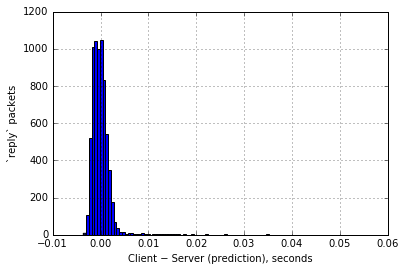

In [21]:
pd.Series(fiterr).hist(bins=100)
plt.xlabel(u'Client − Server (prediction), seconds')
plt.ylabel('`reply` packets') ;

As such, the difference between prediction and the actual wall clock is quite low. Given the assumption that the server TCP Timestamp ticks uniformly with 250 Hz frequency it means that RTT between the client and the server is quite stable, so RTT delay is *not* caused by bufferbloat due to RTT peaks at ~2s, ~3s, ~4s. Bufferbloat causing that large delay would produce much larger `fiterr` variance. This means that:

* all the packets the client gets are usual TCP retransmissions bypassing the filter
* no "original transmissions" bypass the filter

The above analysis refutes the hypothesis of the throttling
caused by Bufferbloat.